In [1]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import detect_edges
%matplotlib inline

Using TensorFlow backend.


In [2]:
scanner = load_model('scanner.keras')

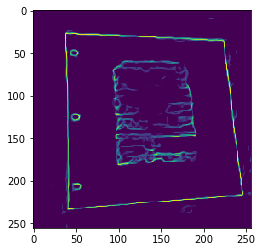

In [3]:
image_document = 'page.jpg'
edges_page = detect_edges.predict_custom_image(image_document, model=scanner)

plt.imshow(edges_page)

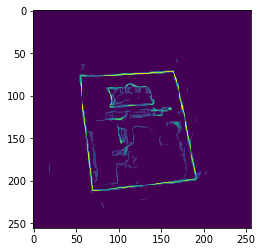

In [4]:
receipt = 'receipt.jpg'
edges_receipt = detect_edges.predict_custom_image(receipt, model=scanner)

plt.imshow(edges_receipt)

In [142]:
new_page = edges_page > 0.7
new_page = new_page.astype(int)

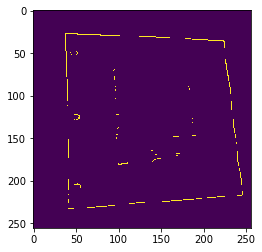

In [143]:
plt.imshow(new_page)

In [144]:
new_receipt = edges_receipt > 0.5
new_receipt = new_receipt.astype(int)

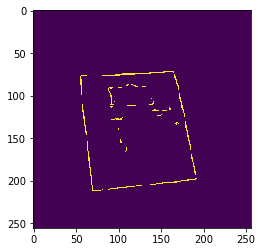

In [145]:
plt.imshow(new_receipt)

In [146]:
import numpy as np
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line as _prob_hough_line)


def _probabilistic_hough_line(image, threshold=0.5, line_length=50, line_gap=10,
                             theta=None):
    
    if image.ndim != 2:
        raise ValueError('The input image `image` must be 2D.')

    if theta is None:
        theta = np.pi / 2 - np.arange(180) / 180.0 * np.pi

    return _prob_hough_line(image, threshold=threshold, line_length=line_length,
                            line_gap=line_gap, theta=theta)


In [147]:
import numpy as np
import imageio
import math
from skimage.transform import (hough_line, hough_line_peaks)

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=0.3):
   
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    #ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(accumulator, thetas, rhos)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, img.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, img.shape[1]))
    ax[2].set_ylim((img.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [148]:
accumulator, thetas, rhos = hough_line(edges_receipt)

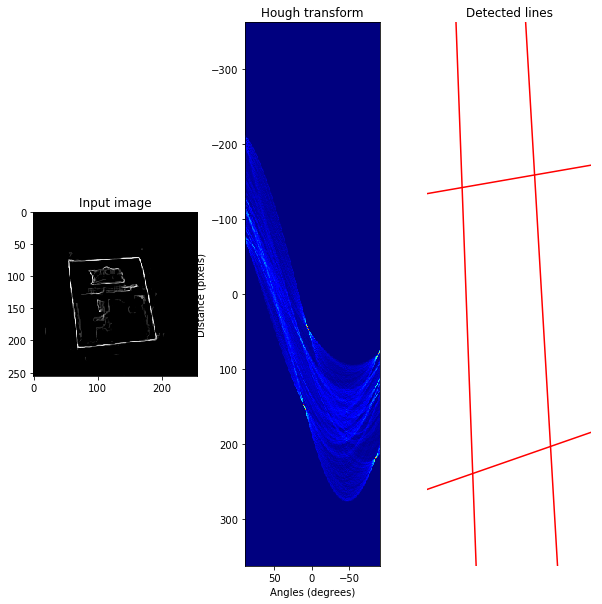

In [149]:
show_hough_line(edges_receipt, accumulator,thetas,rhos, save_path='receipt_output.png')

In [150]:
accumulator, thetas, rhos = hough_line(edges_page)

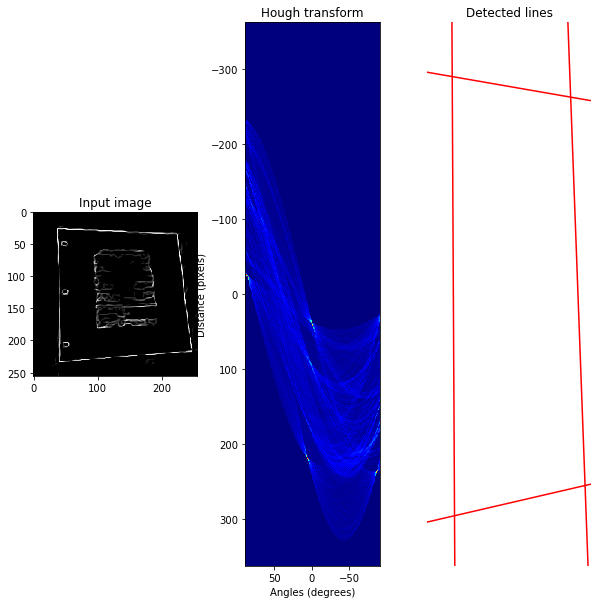

In [151]:
show_hough_line(edges_page, accumulator,thetas,rhos, save_path='page_output.png')

In [152]:
lines = _probabilistic_hough_line(new_receipt)
len(lines)

10

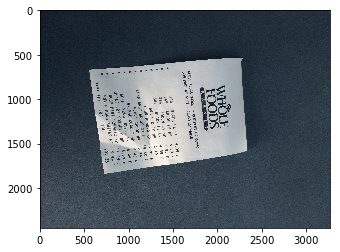

In [153]:
receipt_actual = cv2.imread('receipt.jpg')
plt.imshow(receipt_actual)

In [154]:
receipt_actual = cv2.resize(receipt_actual, (256,256))

In [155]:
receipt_actual.shape

(256, 256, 3)

In [156]:
(h, w) = receipt_actual.shape[:2]
center = (w / 2, h / 2)
M = cv2.getRotationMatrix2D(center, 90, 1.0)
receipt_rotated = cv2.warpAffine(receipt_actual, M, (w, h))

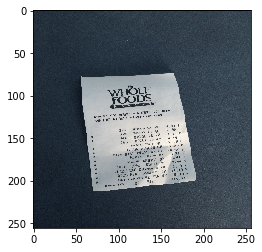

In [157]:
plt.imshow(receipt_rotated)

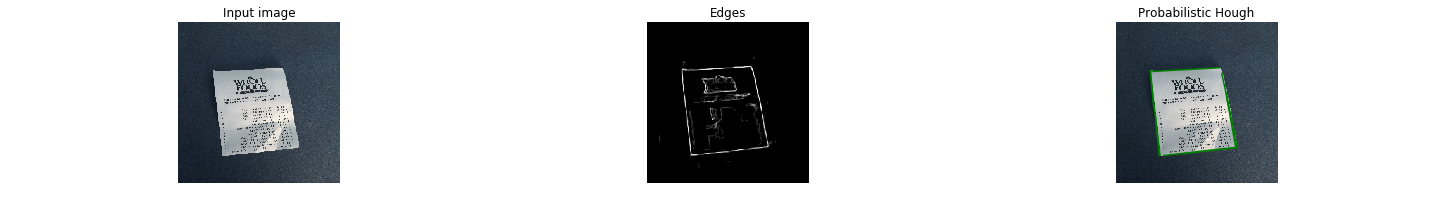

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(receipt_rotated)
ax[0].set_title('Input image')

ax[1].imshow(edges_receipt, cmap=cm.gray)
ax[1].set_title('Edges')

ax[2].imshow(receipt_rotated)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]),color = 'green')
ax[2].set_xlim((0, edges_receipt.shape[1]))
ax[2].set_ylim((edges_receipt.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [159]:
lines = _probabilistic_hough_line(new_page)
len(lines)

7

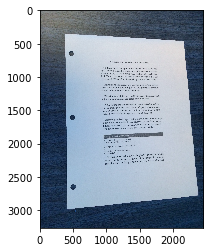

In [160]:
page_actual = cv2.imread('page.jpg')
plt.imshow(page_actual)

In [161]:
page_resized = cv2.resize(page_actual, (256,256))

In [162]:
page_resized.shape

(256, 256, 3)

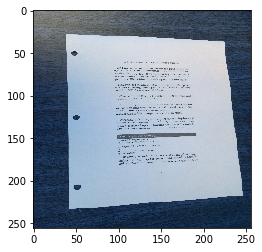

In [163]:
plt.imshow(page_resized)

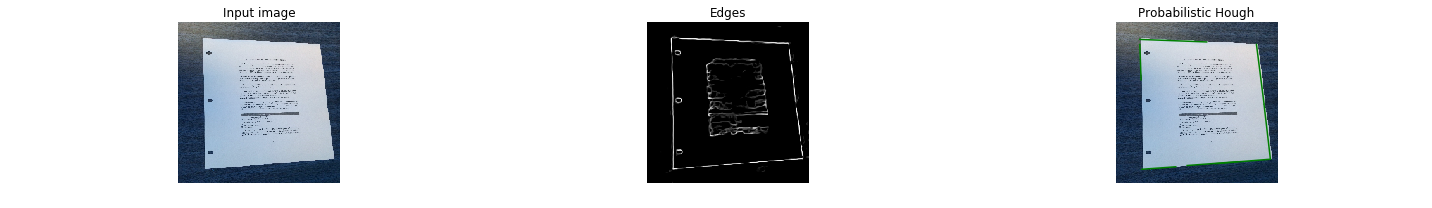

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(page_resized)
ax[0].set_title('Input image')

ax[1].imshow(edges_page, cmap=cm.gray)
ax[1].set_title('Edges')

ax[2].imshow(page_resized)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]), color = 'green')
ax[2].set_xlim((0, edges_page.shape[1]))
ax[2].set_ylim((edges_page.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()